# Canadian Crop Yield Forecasting (Monthly)

- Business Goal: predict future major grain yield to understand the supply market in Canada
- What to forecast: monthly yield of oats for province Ontario based on other factors
- Horizon: 6 month ahead
- Data: [Stats Canada - Producer deliveries of major grain](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3210035101)

Code Reference: https://github.com/jiwidi/time-series-forecasting-with-python

In [ ]:
import warnings

import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import statsmodels as sm
import tensorflow as tf
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
print(tf.__version__)

2.8.2


## Load the dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/forecasting/ca_grain_production_data.csv', parse_dates=['REF_DATE'])
df.head()

,REF_DATE,GEO,DGUID,Type of grain,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1966-08-01,Manitoba,2016A000246,"All grains, total",Tonnes,288,units,0,v40095,4.1,289506.0,NaN,NaN,NaN,0
1,1966-08-01,Manitoba,2016A000246,"Wheat, total",Tonnes,288,units,0,v40096,4.2,138233.0,NaN,NaN,NaN,0
2,1966-08-01,Manitoba,2016A000246,"Wheat, excluding durum",Tonnes,288,units,0,v40097,4.3,137030.0,NaN,NaN,NaN,0
3,1966-08-01,Manitoba,2016A000246,Durum wheat,Tonnes,288,units,0,v40098,4.4,1203.0,NaN,NaN,NaN,0
4,1966-08-01,Manitoba,2016A000246,Oats,Tonnes,288,units,0,v40099,4.5,53863.0,NaN,NaN,NaN,0


## Preprocessing

1. Clean qualititative columns and filtering out dates with missing data entries
1. Rename columns
1. Pivot GEO and Type of Grain columns into multiple predictor columns
1. Impute NULL values using window mean approaches

In [ ]:
print(df.GEO.value_counts())
print(df.UOM.value_counts())

Manitoba             6021
Saskatchewan         6021
Alberta              6021
Western Canada       4401
Prairie provinces    4401
British Columbia     4401
Canada               2241
Eastern Canada       1494
Quebec               1494
Ontario              1494
Name: GEO, dtype: int64
Tonnes    37989
Name: UOM, dtype: int64


In [ ]:
# Explore the data range (min max) for differnet GEO regions
def check_date_range():
  names = ['Ontario', 'Canada', 'Western Canada', 'Manitoba']
  for name in names:
    print(f'\nColumn name: {name}')
    print(df[df.GEO == name].REF_DATE.min())
    print(df[df.GEO == name].REF_DATE.max())
    
check_date_range()


Column name: Ontario
2001-08-01 00:00:00
2022-04-01 00:00:00

Column name: Canada
2001-08-01 00:00:00
2022-04-01 00:00:00

Column name: Western Canada
1981-08-01 00:00:00
2022-04-01 00:00:00

Column name: Manitoba
1966-08-01 00:00:00
2022-04-01 00:00:00


### Filtering and renaming

In [ ]:
# Filtering from 2002 to 2022 and drop qualititave columns
df = df[df.REF_DATE >= '2002-01-01']
# Check date range again
check_date_range()
# Drop unneeded columns
df = df.loc[:, ['REF_DATE', 'GEO', 'Type of grain', 'VALUE']]
# Rename columns + set date to be the index
df.columns = ['date', 'geo', 'grain_type', 'value']
df.head()


Column name: Ontario
2002-01-01 00:00:00
2022-04-01 00:00:00

Column name: Canada
2002-01-01 00:00:00
2022-04-01 00:00:00

Column name: Western Canada
2002-01-01 00:00:00
2022-04-01 00:00:00

Column name: Manitoba
2002-01-01 00:00:00
2022-04-01 00:00:00


,date,geo,grain_type,value
18225,2002-01-01,Canada,"All grains, total",2196180.0
18226,2002-01-01,Canada,"Wheat, total",1399565.0
18227,2002-01-01,Canada,"Wheat, excluding durum",1101486.0
18228,2002-01-01,Canada,Durum wheat,298080.0
18229,2002-01-01,Canada,Oats,116709.0


### Pivot and drop columns

In [ ]:
# Concat GEO + Type of grain together into one variable
df['geo_grain_type'] = df['geo'] + ' - ' + df['grain_type']

df = df.drop(labels=['geo', 'grain_type'], axis=1)
df.set_index('date')


,value,geo_grain_type
date,,
2002-01-01,2196180.0,"Canada - All grains, total"
2002-01-01,1399565.0,"Canada - Wheat, total"
2002-01-01,1101486.0,"Canada - Wheat, excluding durum"
2002-01-01,298080.0,Canada - Durum wheat
2002-01-01,116709.0,Canada - Oats
...,...,...
2022-04-01,2900.0,British Columbia - Oats
2022-04-01,3100.0,British Columbia - Barley
2022-04-01,0.0,British Columbia - Rye


In [ ]:
# Pivot geo_grain_type rows into multiple columns
df = df.pivot(index='date', columns='geo_grain_type', values='value')

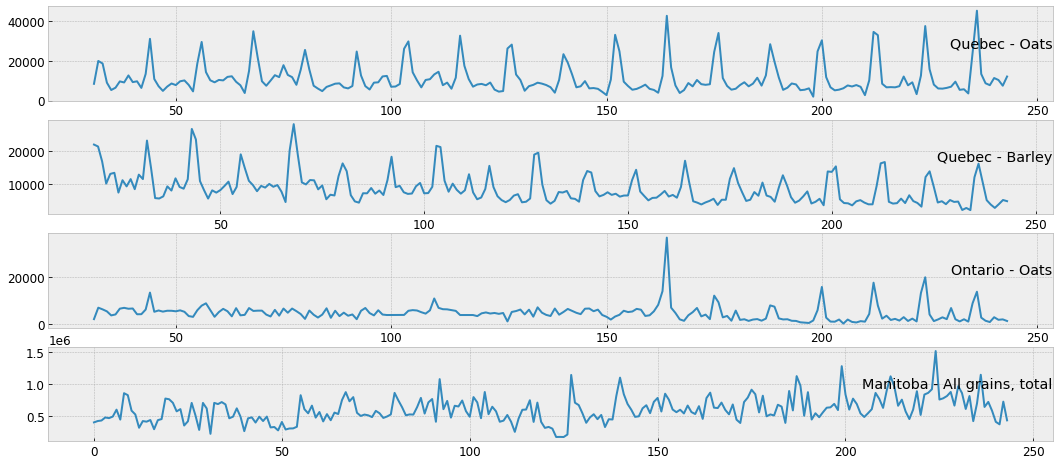

In [ ]:
values = df.values
groups = [60, 58, 45, 33]
# Pick some columns that contain nulls and plot out the ts plot
for i, group in enumerate(groups):
    plt.subplot(len(groups), 1, i+1)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')

plt.show()

### Impute missing values

Using multivariate imputing technique.

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp_result = imp.fit_transform(df.iloc[:, 1:])


In [ ]:
df.iloc[:, 1:] = imp_result
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 244 entries, 2002-01-01 to 2022-04-01
Data columns (total 81 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Alberta - All grains, total                 244 non-null    float64
 1   Alberta - Barley                            244 non-null    float64
 2   Alberta - Canola (rapeseed)                 244 non-null    float64
 3   Alberta - Durum wheat                       244 non-null    float64
 4   Alberta - Flaxseed                          244 non-null    float64
 5   Alberta - Oats                              244 non-null    float64
 6   Alberta - Rye                               244 non-null    float64
 7   Alberta - Wheat, excluding durum            244 non-null    float64
 8   Alberta - Wheat, total                      244 non-null    float64
 9   British Columbia - All grains, total        244 non-null    float64


## Decomposing TS

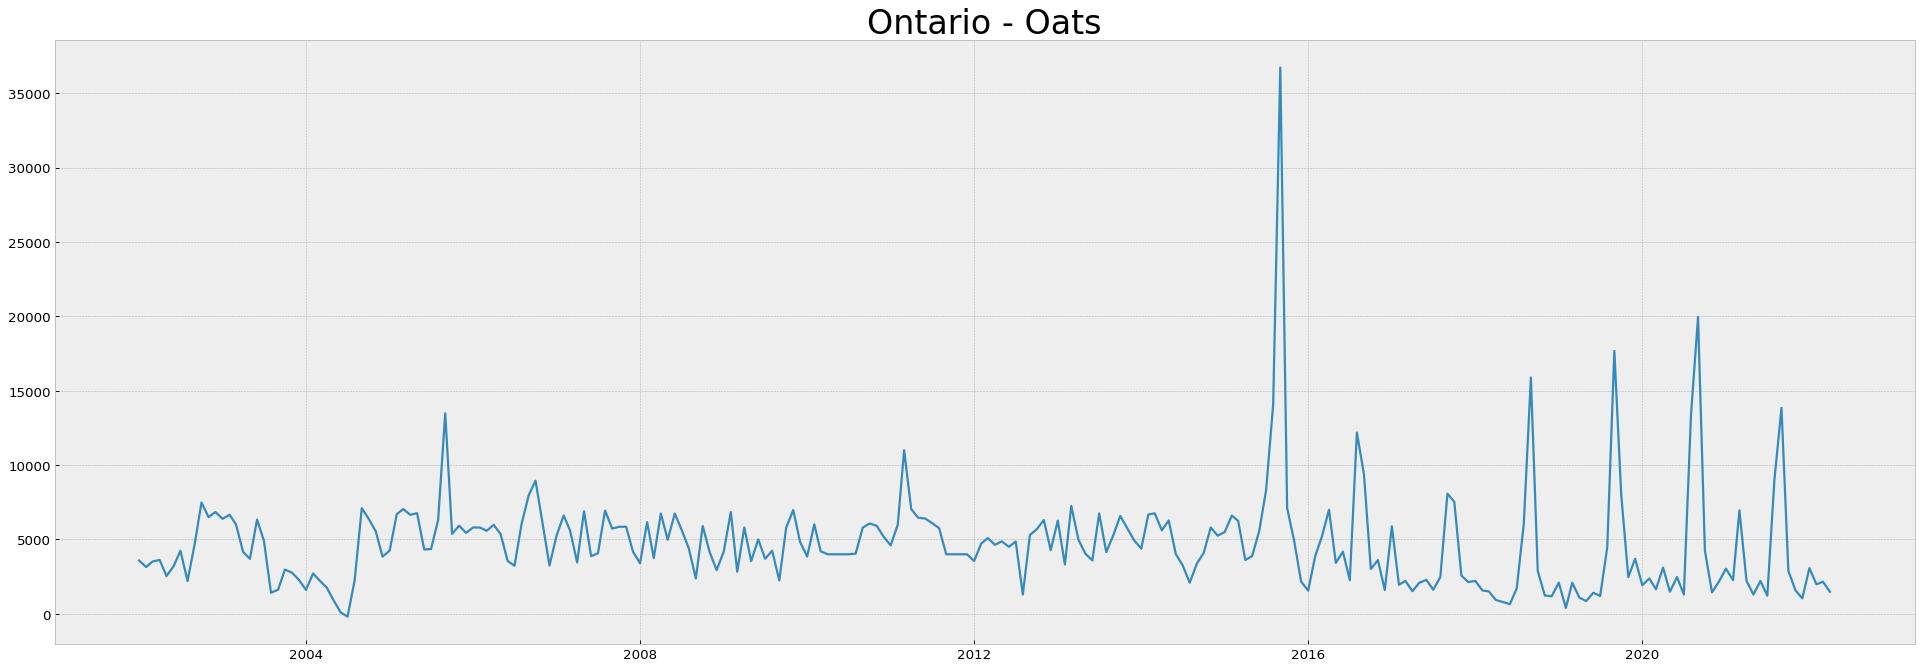

In [ ]:
plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('Ontario - Oats', fontsize=30)

plt.plot(df.iloc[:, 45])

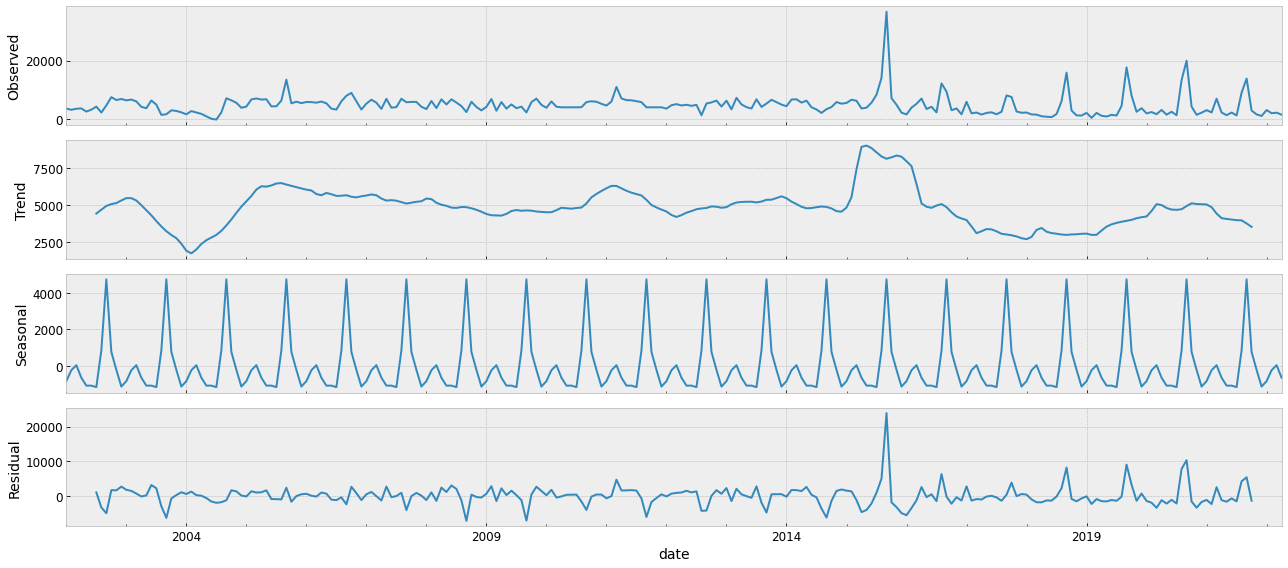

<Figure size 4000x1600 with 0 Axes>

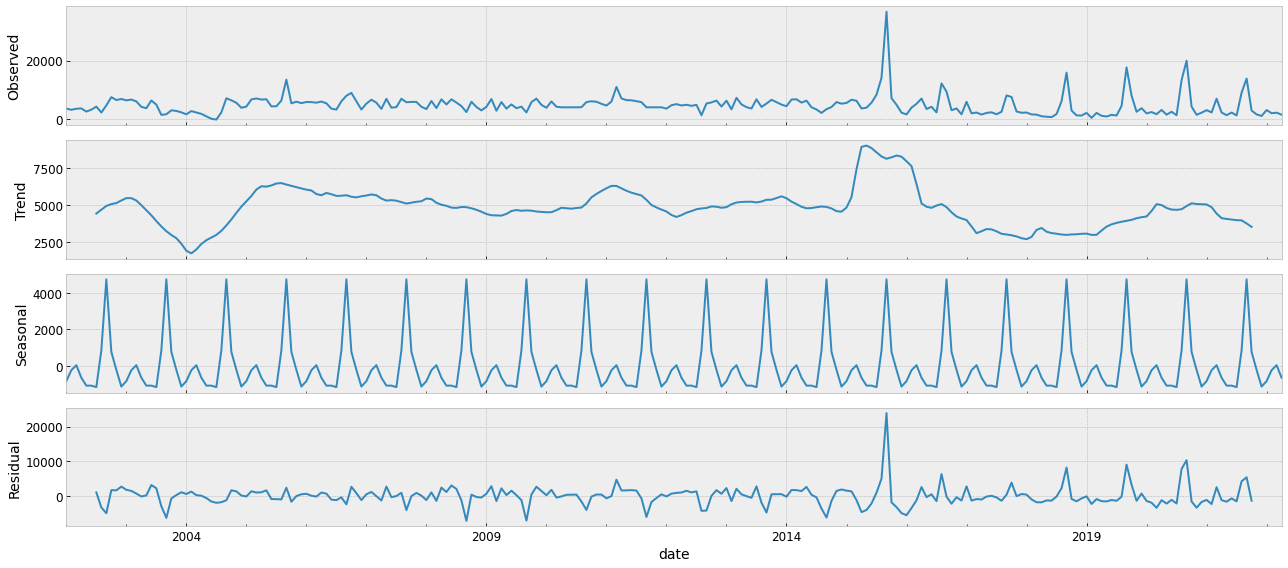

In [ ]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = df.iloc[:,45]
result = seasonal_decompose(series, model='additive')
result.plot()

### Seasonality
Scope to only 2 years to identify the seasonalty.

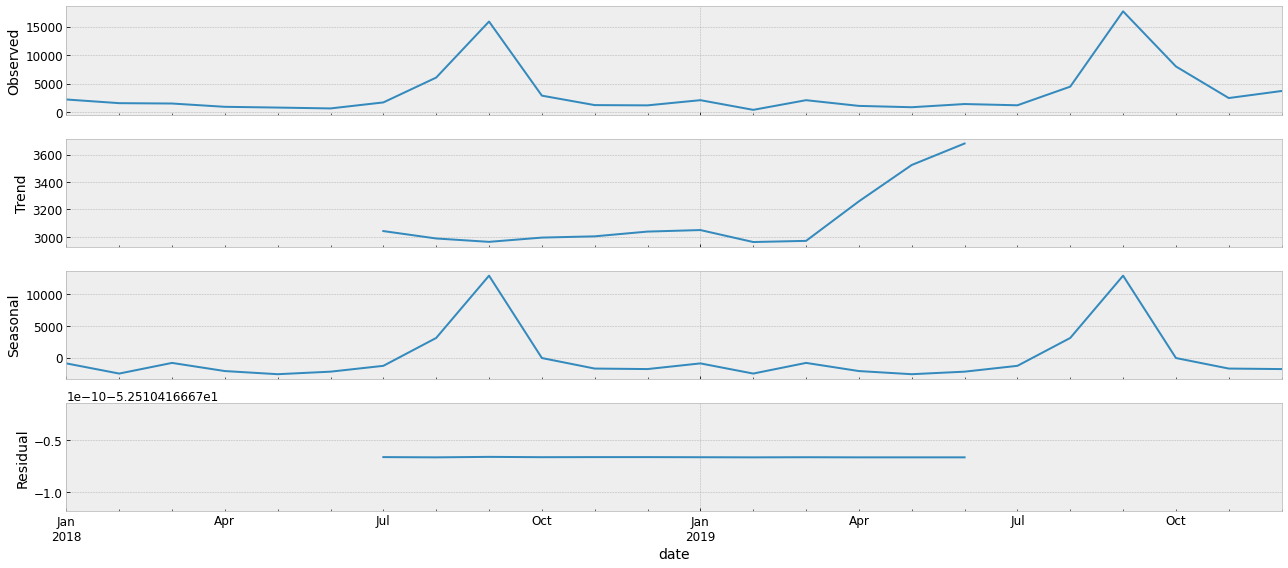

<Figure size 4000x1600 with 0 Axes>

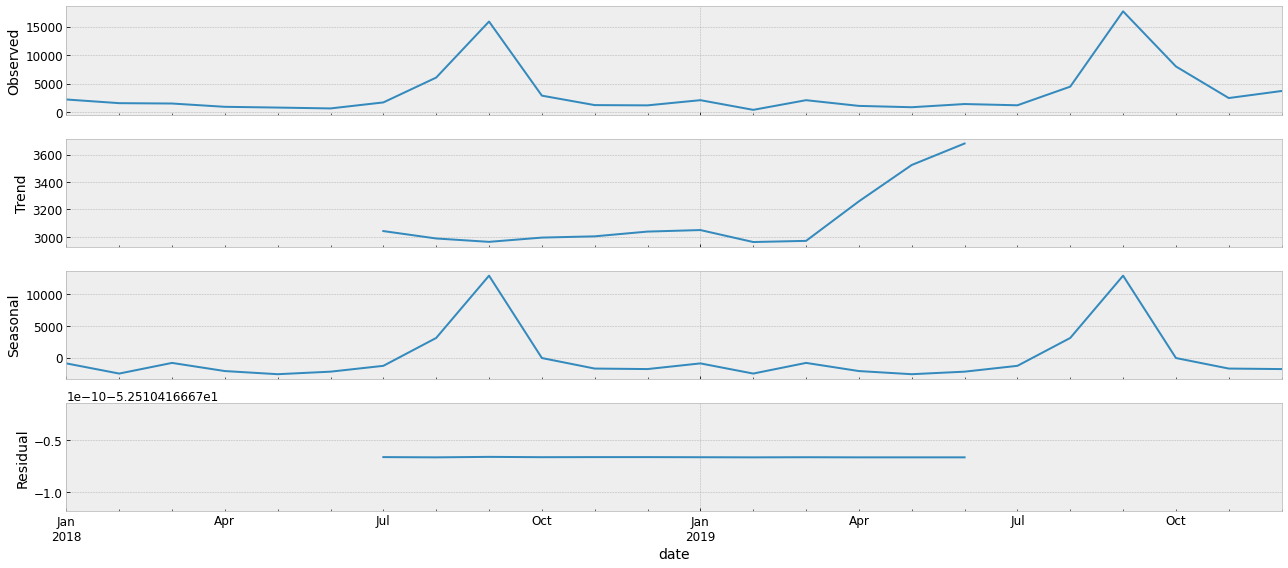

In [ ]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series_2yr = df.iloc[:,45][(df.index >= '2018-01-01') & (df.index < '2020-01-01')]
result = seasonal_decompose(series_2yr, model='additive')
result.plot()

We see a seasonality happens around Sept every year and that should be the harvesting season.

### Noise
Our time series will also have a noise component to them, most likely white noise. We say white noise is present if the measurement are independent and identically distributed with a mean of zero. This will mean all our measurements have same variance and no correlation with the rest of values in the series.

If our time series has white noise this will mean we can't predict that component of the series (as is random) and we shoul aim to produce a model with errors close to this white noise.

How to check if our series has white noise?

- Check our series histogram, does it look like a Gaussian distribution? Mean=0 and constand std
- Correlation plots
- Standard deviation distribution, is it a Gaussian distribution?
- Does the mean or level change over time?

Text(0.5, 1.0, 'Mean over time')

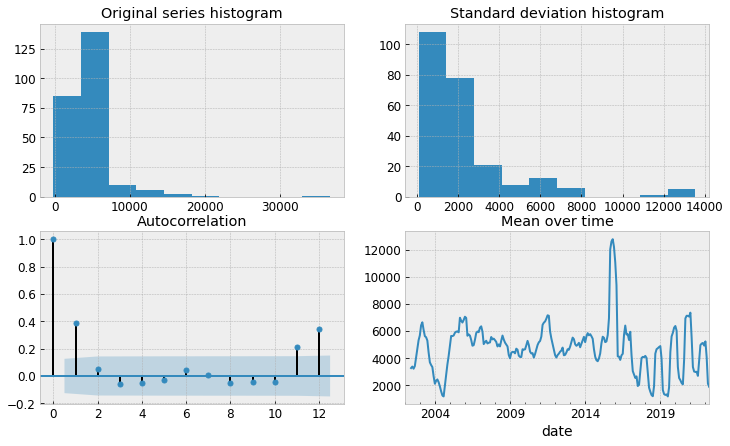

In [ ]:
fig = plt.figure(figsize=(12, 7))
layout = (2, 2)
hist_ax = plt.subplot2grid(layout, (0, 0))
ac_ax = plt.subplot2grid(layout, (1, 0))
hist_std_ax = plt.subplot2grid(layout, (0, 1))
mean_ax = plt.subplot2grid(layout, (1, 1))

df.iloc[:,45].hist(ax=hist_ax)
hist_ax.set_title("Original series histogram")

plot_acf(series, lags=12, ax=ac_ax)
ac_ax.set_title("Autocorrelation")

mm = df.iloc[:,45].rolling(6).std()
mm.hist(ax=hist_std_ax)
hist_std_ax.set_title("Standard deviation histogram")

mm = df.iloc[:, 45].rolling(6).mean()
mm.plot(ax=mean_ax)
mean_ax.set_title("Mean over time")

We can see our series do not follow a Gaussian distribution from the histogram and neither the standard deviation, thought the std does has the mean more centered which shows a small part of white noise that is not possible to split from the original series (this will happen most of the times, specially is real life datasets)).

We could say our series does contain a small part of white noise but it is really small and hard to remove

## Stationarity

Stationarity is an important characteristic of time series. A time series is stationarity if it has constant mean and variance over time. Most models work only with stationary data as this makes it easier to model. Not all time series are stationary but we can transform them into stationary series in different ways.

Often, stock prices are not a stationary process, since we might see a growing trend, or its volatility might increase over time (meaning that variance is changing).

### Check for sationarity

#### Autocorrelation and Partial autocorrelation plots

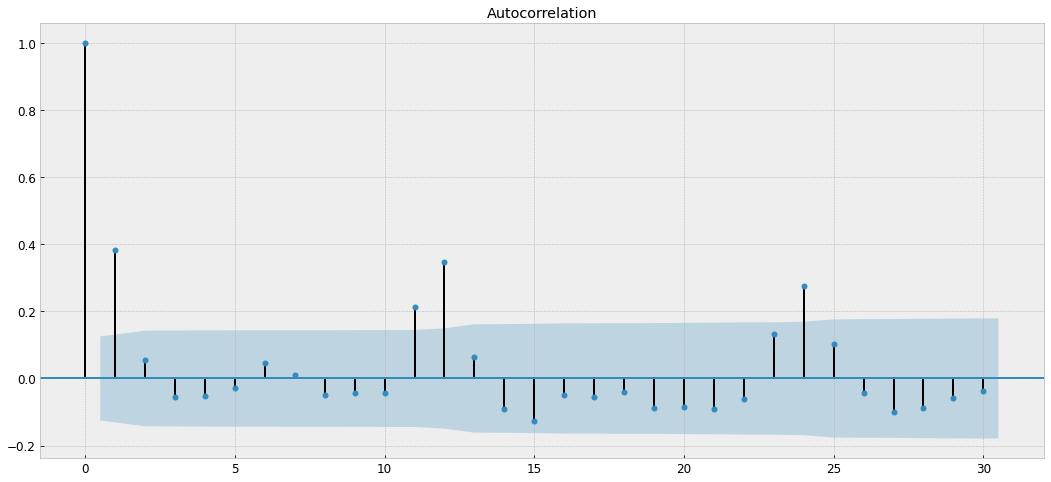

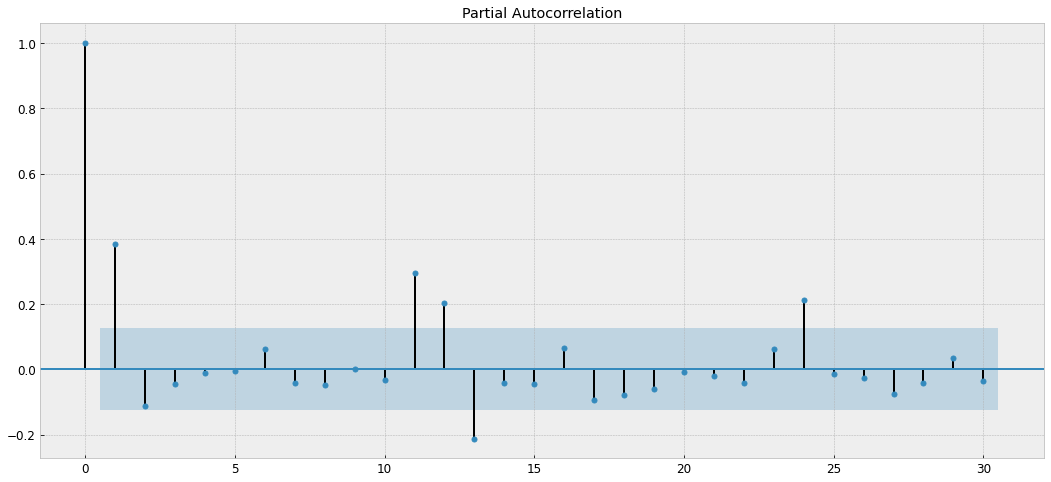

In [ ]:
plot_acf(series, lags=30)
plot_pacf(series, lags=30)
plt.show()

We saw that our time series values are not correlated with distant points in time, this is good and shows us our series should be stationary but for the shake of learning and confirming we will test with some other methods

#### Rolling means and standard deviation of our series

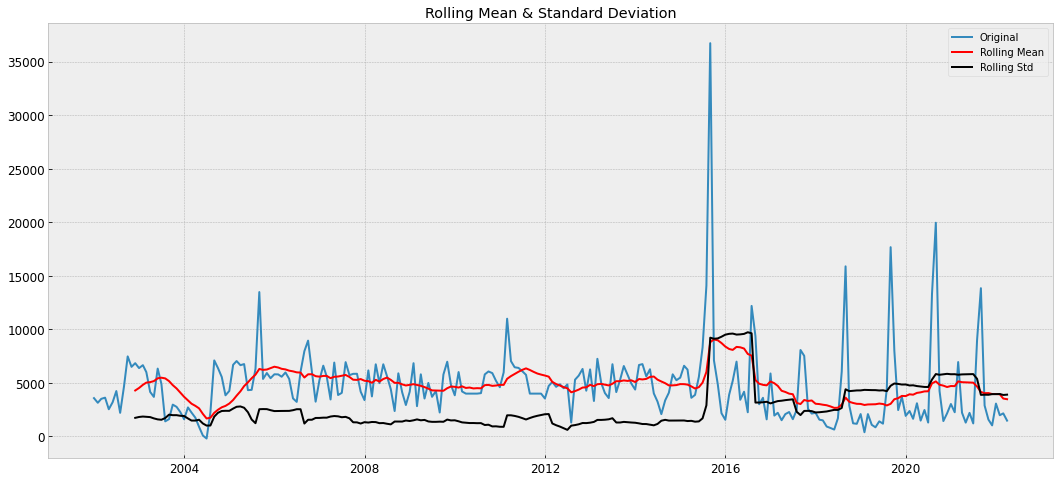

In [ ]:
# Determing rolling statistics
rolmean = series.rolling(window=12).mean()
rolstd = series.rolling(window=12).std()

# Plot rolling statistics:
orig = plt.plot(series, label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

We can see how our mean and standar deviation have a constant behaviour over the years, even if they change over the year this behaviour is then repeated next year. This proves us again a stationary series

#### Augmented Dickey-Fuller test

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary. p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary. Below is an example of calculating the Augmented Dickey-Fuller test on the Daily Female Births dataset. The statsmodels library provides the adfuller() function that implements the test.

In [ ]:
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.215684
p-value: 0.019095
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.573


A method to quickly perform all the previous methods into one single function call and a pretty graph :)



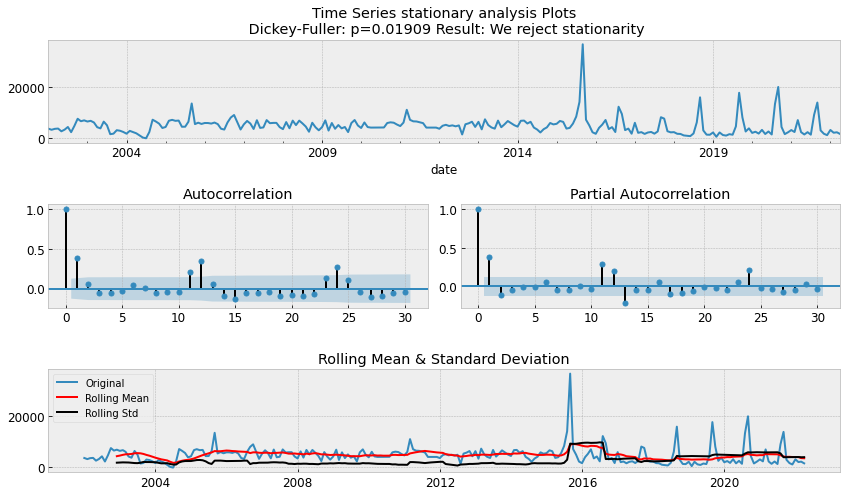

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=(12, 7))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        mean_std_ax = plt.subplot2grid(layout, (2, 0), colspan=2)
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        hypothesis_result = "We reject stationarity" if p_value <= 0.05 else "We can not reject stationarity"
        ts_ax.set_title(
            'Time Series stationary analysis Plots\n Dickey-Fuller: p={0:.5f} Result: {1}'.format(p_value, hypothesis_result))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

        rolmean = y.rolling(window=12).mean()
        rolstd = y.rolling(window=12).std()

        # Plot rolling statistics:
        orig = plt.plot(y, label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label='Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')


tsplot(series, lags=30)

### Making time series staionary

There're multiple approaches to remove the series dependence on time.

- Different transform
- Log scale transformation
- Smoothing (With smotthing we will take rolling averages over periods of time. Is a bit tricky to choose the best windows #MORE ON THIS IN NEXT SECTION WITH AUTO WINDOWS)


## Export Processed Data

Export processed dataset for next modelling step.

In [ ]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/forecasting/processed_data.csv')